<a href="https://colab.research.google.com/github/Fyfy1996/Natural_language_understanding/blob/master/hw3_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Word Embeddings

In this homework assignment, we are going to tackle two different exercises involving word embeddings. First, we are going to explore using the semantic orientation method to score words. Second, we will explore the effect of context sizes in building embeddings based on word cooccurrences.

# Part 0: Setup

In [0]:
!pip install sacremoses

     |████████████████████████████████| 870kB 2.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=617c7b67951e48c5b4e300fe2695a01d2c4d3c572f1da80209a9e7d30769607e
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import sacremoses
import tqdm
import time
from matplotlib import pyplot as plt
%matplotlib inline

We're going load a set of 50D word vectors from GloVe. If want to download other versions of GloVe, you can click [here](https://nlp.stanford.edu/projects/glove/).

In [0]:
!wget https://docs.google.com/uc?id=1si-rTb4nALWb-Wah5_tqbs9KXAwE3qhK -O glove.aa
!wget https://docs.google.com/uc?id=1_XywxYH56-tHepqxpUfE-Y6xNQSZiu-7 -O glove.ab
!wget https://docs.google.com/uc?id=1ISSLqQWL8EO8blT54RKahkDQhtmSp9ae -O glove.ac
!wget https://docs.google.com/uc?id=1qHqCKLFO0Zdyhmb_ctd63aaFRLNGiDfB -O glove.ad
!cat glove.?? > 'glove.6B.50d.txt'

--2020-02-23 17:06:39--  https://docs.google.com/uc?id=1si-rTb4nALWb-Wah5_tqbs9KXAwE3qhK
Resolving docs.google.com (docs.google.com)... 108.177.13.101, 108.177.13.113, 108.177.13.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kt4gviibpuuncdhreh4sasb3adjngd4d/1582477200000/14514704803973256873/*/1si-rTb4nALWb-Wah5_tqbs9KXAwE3qhK [following]
--2020-02-23 17:06:41--  https://doc-00-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kt4gviibpuuncdhreh4sasb3adjngd4d/1582477200000/14514704803973256873/*/1si-rTb4nALWb-Wah5_tqbs9KXAwE3qhK
Resolving doc-00-0g-docs.googleusercontent.com (doc-00-0g-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-00-0g-docs.googleusercontent.com (doc-00-0g-docs.googleusercontent.com)|172.217.20

We'll load the GloVe embeddings similar to previous labs. `words_to_load` specifies how many word vectors we want to load. The words are saved in frequency order, so specifying 50,000 means that we only want to work with the 50,000 most frequent words from the source corpus.

In [0]:
words_to_load = 50000

with open('./glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((words_to_load, 50))
    words_to_index = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words_to_index[s[0]] = i
        ordered_words.append(s[0])
print("GloVe loaded")

GloVe loaded


Let's look at the embedding for the word "potato".

In [0]:
loaded_embeddings[words_to_index['potato']]

array([-0.063054, -0.62636 , -0.76417 , -0.041484,  0.56284 ,  0.86432 ,
       -0.73734 , -0.70925 , -0.073065, -0.74619 , -0.34769 ,  0.14402 ,
        1.4576  ,  0.034688,  0.11224 ,  0.13854 ,  0.10484 ,  0.60207 ,
        0.021777, -0.21802 ,  0.087613, -1.4234  ,  1.0361  ,  0.1509  ,
        0.13608 , -0.2971  , -0.90828 ,  0.34182 ,  1.3367  ,  0.16329 ,
        1.2374  , -0.20113 , -0.91532 ,  1.4222  , -0.1276  ,  0.69443 ,
       -1.1782  ,  1.2072  ,  1.0524  , -0.11957 , -0.1275  ,  0.41798 ,
       -0.9232  , -0.1312  ,  1.2696  ,  1.2318  ,  0.30061 , -0.18854 ,
        0.15899 ,  0.0486  ])

# Part 1: The Semantic Orientation Method [40]

The __semantic orientation__ method of [Turney and Littman 2003](http://doi.acm.org/10.1145/944012.944013) is a method for automatically scoring words along some single semantic dimension like sentiment. It works from a pair of small seed sets of words that represent two opposing points on that dimension.

*Some code in this section was adapted from Stanford CS 224U*

Here's a sample pair of seed sets:

In [0]:
positive_words = ['good', 'great', 'awesome', 'like', 'love']
negative_words = ['bad', 'awful', 'terrible', 'hate', 'dislike']

In [0]:
class SemanticOrientation:
    
    def __init__(self, seed_pos, seed_neg):
        """
        args: 
            - seed_pos: list of 'positive' words
            - seed_neg: list of 'negative' words
        """
        self.seed_pos = seed_pos
        self.seed_neg = seed_neg
        seed_pos_indices = [words_to_index[seed] for seed in seed_pos]
        seed_neg_indices = [words_to_index[seed] for seed in seed_neg]
        
        # Get matrices of embeddings for positive and negative words
        self.seed_pos_mat = loaded_embeddings[seed_pos_indices]
        self.seed_neg_mat = loaded_embeddings[seed_neg_indices]
        
    def determine_coefficient(self, candidate_words):
        """
        args:
            - candidate_words: single word, or list of words
        """
        
        # Optionally handle a single word
        one_word = isinstance(candidate_words, str)
        if one_word:
            candidate_words = [candidate_words]

        # Retrieve matrix of embeddings for candidate words
        candidates_mat = np.array([
            loaded_embeddings[words_to_index[candidate_word]]
            for candidate_word in candidate_words
        ])
        # Compute the cosine similarity between the seed word and 
        #   the candidate word embeddings, and average
        pos_sim = cosine_similarity(self.seed_pos_mat, candidates_mat).mean(axis=0)
        neg_sim = cosine_similarity(self.seed_neg_mat, candidates_mat).mean(axis=0)
        # Compute the difference between the average positive and negative similarities
        diff = pos_sim - neg_sim

        if one_word:
            return diff[0]
        else:
            return diff

In [0]:
sentiment_so = SemanticOrientation(
    seed_pos=positive_words,
    seed_neg=negative_words,
)

Let's get the coefficients of some words and see if it lines up with our intuition.

In [0]:
sentiment_so.determine_coefficient('abhorrent')

-0.2712170238375182

In [0]:
sentiment_so.determine_coefficient('excellent')

0.2816580407857993

In [0]:
sentiment_so.determine_coefficient('amazing')

0.2068293944473673

In [0]:
sentiment_so.determine_coefficient('okay')

-0.011928961401575844

In [0]:
sentiment_so.determine_coefficient('atrocious')

-0.2749609244690855

In [0]:
def scatter_and_annotate(ax, x_values, y_values, labels, color):
    ax.scatter(x_values, y_values, color=color)
    for i, label in enumerate(labels):
        ax.text(x_values[i], y_values[i], label, rotation=45)

def plot_semantic_orientation(semantic_orientation, words):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.gca()
    x_values = semantic_orientation.determine_coefficient(semantic_orientation.seed_pos) 
    x_values = semantic_orientation.determine_coefficient(semantic_orientation.seed_pos) 

    scatter_and_annotate(
        ax=ax,
        x_values=semantic_orientation.determine_coefficient(semantic_orientation.seed_pos),
        y_values=[0] * len(semantic_orientation.seed_pos),
        labels=semantic_orientation.seed_pos,
        color="blue",
    )
    scatter_and_annotate(
        ax=ax,
        x_values=semantic_orientation.determine_coefficient(semantic_orientation.seed_neg),
        y_values=[0] * len(semantic_orientation.seed_neg),
        labels=semantic_orientation.seed_neg,
        color="red",
    )
    ax.axhline(0, color="gray")

    scatter_and_annotate(
        ax=ax,
        x_values=semantic_orientation.determine_coefficient(words),
        y_values=[-2] * len(words),
        labels=words,
        color="purple",
    )
    ax.axhline(-2, color="black")
    ax.set_ylim(-2.5, 1)
    ax.set_yticks([-2, 0])
    ax.set_yticklabels(["words", "seed"])

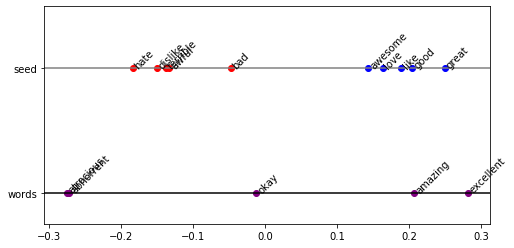

In [0]:
plot_semantic_orientation(
    semantic_orientation=sentiment_so, 
    words=["abhorrent", "excellent", "amazing", "okay", "atrocious"],
)

And sort our vocabulary by its score along the axis. For now, we're only scoring frequent words, since this process can be slow.

### Question 1.1 [10]

Using `sentiment_so`, compute the coefficients of all `ordered_words` and show the 10 most positive and 10 most negative words.

In [0]:
def show_tops(sentiment_so, ordered_words, tops):
  order_words_so = pd.Series(sentiment_so.determine_coefficient(ordered_words),index=ordered_words).sort_values(ascending=False)
  print("The 10 most positive is \n",order_words_so[:tops],"\n\n")
  print("The 10 most negative is \n",order_words_so[-tops:])
show_tops(sentiment_so, ordered_words, 10)

The 10 most positive is 
 golden       0.332636
alongside    0.322001
famed        0.317862
award        0.315711
named        0.312229
pioneer      0.310568
star         0.306124
eagle        0.305612
diamond      0.304883
master       0.304087
dtype: float64 


The 10 most negative is 
 unjustifiable   -0.312373
profiteering    -0.312473
complicit       -0.322153
avoidable       -0.322462
malfeasance     -0.323151
inexcusable     -0.329084
cautioning      -0.339960
mongering       -0.342252
inaction        -0.352449
deplore         -0.356517
dtype: float64


### Question 1.2 [30]

1. Create another `SemanticOrientation` object with a different set of contrasting "positive" and "negative" categories that are unrelated to sentiment (e.g solids vs. liquids, living things vs objects) and corresponding seed words. Have at least 5 words per category.
2. Pick another 5 words in either category and show their coefficients. Display them using the plotting code from above.
3. Using `ordered_words`, show the 10 most positive and 10 most "negative" words.
4. Pick 2 words that are unrelated to either category, compute their coefficients, and comment on them.

In [0]:
posi_words = ["animal","dog","cat","human","people","pets"]
neg_words = ["rock","river","mountain","tree","ocean","sea"]

so_animal_vs_rock = SemanticOrientation(seed_pos=posi_words, seed_neg=negative_words)

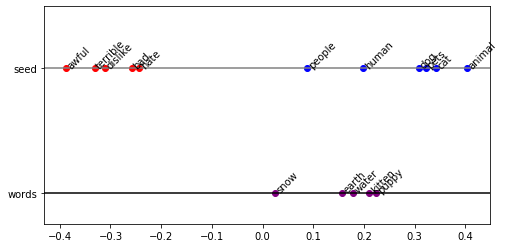

In [0]:
plot_semantic_orientation(
    semantic_orientation=so_animal_vs_rock, 
    words=["water", "puppy", "kitten", "snow", "earth"],
)

In [0]:
show_tops(so_animal_vs_rock, ordered_words, 10)

The 10 most positive is 
 mammal        0.484386
elephant      0.468456
panda         0.457522
parrot        0.453117
cloned        0.439439
inflatable    0.437091
turtle        0.432099
chimpanzee    0.431677
reptile       0.428993
whale         0.420556
dtype: float64 


The 10 most negative is 
 sentimentality     -0.417669
notwithstanding    -0.419955
intransigence      -0.421176
rancor             -0.423538
aggravation        -0.427635
utter              -0.429163
seeming            -0.433223
uncharacteristic   -0.433256
inconsistency      -0.434516
indecision         -0.466489
dtype: float64


In [0]:
words_unrelated = ["cup","glass"]
coefficient = cosine_similarity(loaded_embeddings[words_to_index[words_unrelated[0]]].reshape(1,-1), loaded_embeddings[words_to_index[words_unrelated[1]]].reshape(1,-1))
print("The coefficient between {} and {} is {}".format(words_unrelated[0], words_unrelated[1], float(coefficient)))

The coefficient between cup and glass is 0.28476156067463343


# Part 2: Exploring effect of context size [60 pts]

Let's take a step back and assume we are creating word embeddings from scratch.

We face many implicit and explicit design decisions in creating distributional word representations. In lecture, we discussed creating vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

We're going to download two files:

1. `sst.txt`, a list of sentences from the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/treebank.html).
2. `MTURK-771.csv`, a [word-relatedness dataset](http://www2.mta.ac.il/~gideon/mturk771.html).

In [0]:
!wget https://docs.google.com/uc?id=1uDpAm-eoZx-kS7UAPELfH0gGAxekkDVd -O sst.txt
!wget http://www2.mta.ac.il/~gideon/datasets/MTURK-771.csv -O MTURK-771.csv

--2020-02-23 17:06:56--  https://docs.google.com/uc?id=1uDpAm-eoZx-kS7UAPELfH0gGAxekkDVd
Resolving docs.google.com (docs.google.com)... 173.194.216.102, 173.194.216.113, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1uq069fvg2904svcn2flauaqc2mvta67/1582477200000/14514704803973256873/*/1uDpAm-eoZx-kS7UAPELfH0gGAxekkDVd [following]
--2020-02-23 17:06:57--  https://doc-00-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1uq069fvg2904svcn2flauaqc2mvta67/1582477200000/14514704803973256873/*/1uDpAm-eoZx-kS7UAPELfH0gGAxekkDVd
Resolving doc-00-0g-docs.googleusercontent.com (doc-00-0g-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-00-0g-docs.googleusercontent.com (doc-00-0g-docs.googleusercontent.com)|172.21

In [0]:
mturk_path = "./MTURK-771.csv"
sst_path = "./sst.txt"

First, we will load the SST data.

In [0]:
def load_sst(sst_path):
    tokenizer = sacremoses.MosesTokenizer()
    results = []
    for line in tqdm.tqdm_notebook(pd.read_csv(sst_path, sep="\t")["sentence"].values):
        results.append(tokenizer.tokenize(line))
    return results
data = load_sst(sst_path)

### Question 2.1 [45]

Implement:
* `get_token_frequencies_and_cooccurrences`
* `prune_vocabulary`
* `build_cooccurrence_mat_from_counts`

Each of these will be used in  `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. 

In [0]:
import math

In [0]:
def build_cooccurrence_matrix(data, max_vocab_size=20000, context_size=2, verbose=True):
    """ 
    args:
        - data: iterable where each item is a string sentence
        - max_vocab_size: maximum vocabulary size
        
    returns:
        - coocur_mat: co-occurrence matrix as a numpy array
    """
    if verbose:
        print("Counting words...")
    start_time = time.time()
    tok2freq, cooccur_counts = get_token_frequencies_and_cooccurrences(data, context_size)
    if verbose:
        print("\tFinished counting %d words in %.5f" % (len(tok2freq), time.time() - start_time))
        print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    if verbose:
        print("\tFinished pruning vocabulary to %d words in %.5f" % (len(tok2idx), time.time() - start_time))
        print("Building co-occurrence matrix...")
    start_time = time.time()
    cooccur_mat = build_cooccurrence_mat_from_counts(idx2tok, cooccur_counts)
    if verbose:
        print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    return cooccur_mat, tok2idx, idx2tok, cooccur_counts

In [0]:
from collections import defaultdict

def get_token_frequencies_and_cooccurrences(data, context_size):
    """ 
    Compute token frequencies and cooccurrences from data

    args: 
        - data: a list of list of words (or tokens)
        - context_size: the vocabulary size to prune to
    
    return:
        A tuple containing:
        - tok2freq: a dictionary mapping from words to count
        - cooccur_counts: a dictionary of dictionaries, where

              cooccur_counts[word1][word2]

          is how often word1 cooccurs with word2 within a given context_size
    """
    tok2freq = defaultdict(int)
    cooccur_counts = defaultdict(lambda: defaultdict(int))

    for datum in data:
        for i, tok in enumerate(datum):
            tok2freq[tok] += 1
            for k in range(context_size + 1):
                # === Exercise Start [1/3] === #
                if i + k < len(datum):
                    cooccur_counts[tok][datum[i + k]] += 1
                # === Exercise End [1/3] === #
    return tok2freq, cooccur_counts

def prune_vocabulary(tok2freq, max_vocab_size):
    """ 
    Prune vocab by taking max_vocab_size most frequent words 

    args: 
        - tok2freq: a dictionary mapping from words to count
        - max_vocab_size: the vocabulary size to prune to
    
    return:
        A tuple containing:
        - tok2idx: a dictionary mapping from words to the index in idx2tok
        - idx2tok: a list of words (the vocabulary), of length max_vocab_size
    """
    
    tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
    # === Exercise Start [2/3] === #
    for i in range(round(math.sqrt(len(tok_and_freqs)))):
      for j in range(len(tok_and_freqs)-1):
        if tok_and_freqs[j][1] <  tok_and_freqs[j+1][1]:
            temp = tok_and_freqs[j]
            tok_and_freqs[j] = tok_and_freqs[j+1]
            tok_and_freqs[j+1] = temp
    tok_and_freqs = tok_and_freqs[:max_vocab_size]
    tok2idx = { item[0]: i  for i, item in enumerate(tok_and_freqs)}
    idx2tok = list(tok2idx.keys())
    
    # === Exercise End [2/3] === #
    return tok2idx, idx2tok

def build_cooccurrence_mat_from_counts(idx2tok, cooccur_counts):
    """ Build a cooccurrence matrix from counts and a vocab
    args:
        - idx2tok: a list of words (the vocabulary), of length N
        - cooccur_counts: a dictionary of dictionaries, where

              cooccur_counts[word1][word2]

          is how often word1 cooccurs with word2
    return:
        - mat: an NxN matrix (symmetric) of the occurrence counts of the
               words in idx2tok
    """
    vocab_size = len(idx2tok)
    mat = np.zeros([vocab_size, vocab_size])
    for i in tqdm.tqdm_notebook(range(vocab_size)):
        for j in range(i, vocab_size):
            # === Exercise Start [3/3] === #
            word1, word2 = idx2tok[i], idx2tok[j]
            counts = cooccur_counts[word1][word2] + cooccur_counts[word2][word1]
            mat[i,j] = counts
            mat[j,i] = counts
            # === Exercise End [3/3] === #
    return mat

Let's build a cooccurrence matrix with `context_size=2`.

In [0]:
mat, tok2idx, idx2tok, _ = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=2)

Counting words...
	Finished counting 21669 words in 0.49126
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00000
Building co-occurrence matrix...



	Finished building co-occurrence matrix in 100.86621


In [0]:
tok1 = "the"
tok2 = "end"
print("'{}' and '{}' co-occur {} times".format(tok1, tok2, mat[tok2idx[tok1]][tok2idx[tok2]]))

'the' and 'end' co-occur 98.0 times


### Question 2.2 [15]

We are going to evaluate the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (the coccurrence matrices).

In this exercise, you will fill in parts of the code in the `evaluate_word_similarity` function. (Hint: make use of the imports we include at the top of the code block; the solution should be pretty short!)

In [0]:
# Hint: some helpful imports!
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity


def load_word_similarity_dataset(data_file):
    mturk_df = pd.read_csv(mturk_path, names=["word1", "word2", "similarity"])
    return mturk_df


def evaluate_word_similarity(mturk_df, mat, tok2idx):
    """ Evaluate the word embeddings by comparing the word similarities 
        to the word similarity scores from the MTurk-771 data.
    Notes:
        - In some cases, the words in the MTurk-771 data may not appear in 
          our vocabulary. In those cases, we will simpy skip over those
          MTurk-771 examples.
        - Use cosine_similarity to compute word similarities, and use
          spearmanr to compute the overall rank correlation.

    args:
        - mturk_df: DataFrame of MTurk-711 data
        - mat: cooccurrence matrix computed from above. These will serve as 
               our word embeddings.
        - idx2tok: a list of words (the vocabulary), of length N

    return:
        - rho: the rank correlation between the predicted word similarities
               and the ground truth word similarities from MTurk-771
    """
    preds = []
    trgs = []
    n_exs = 0
    for row in mturk_df.itertuples():
        if row.word1 in tok2idx and row.word2 in tok2idx:
            # === Exercise Start [1/2] === #
            pred_sim = float(cosine_similarity(mat[tok2idx[row.word1]].reshape(1,-1), mat[tok2idx[row.word2]].reshape(1,-1)))
            # === Exercise End [1/2] === #
            preds.append(pred_sim)
            trgs.append(row.similarity)
            n_exs += 1

    # === Exercise Start [2/2] === #
    rho = spearmanr(preds, trgs)[0]
    # === Exercise End [2/2] === #
    print("Evaluated on %d of %d examples" % (n_exs, len(mturk_df)))
    return rho

In [0]:
mturk_df = load_word_similarity_dataset(mturk_path)
scores = []
context_sizes = [1, 2, 3, 4]
for context_size in context_sizes:
    mat, tok2idx, idx2tok, _ = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=context_size)
    score = evaluate_word_similarity(mturk_df, mat, tok2idx)
    scores.append(score)
print(scores)

Counting words...
	Finished counting 21669 words in 0.34846
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00000
Building co-occurrence matrix...



	Finished building co-occurrence matrix in 101.27655
Evaluated on 197 of 771 examples
Counting words...
	Finished counting 21669 words in 0.47512
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00000
Building co-occurrence matrix...



	Finished building co-occurrence matrix in 111.81448
Evaluated on 197 of 771 examples
Counting words...
	Finished counting 21669 words in 1.45380
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00000
Building co-occurrence matrix...



	Finished building co-occurrence matrix in 108.33731
Evaluated on 197 of 771 examples
Counting words...
	Finished counting 21669 words in 0.71300
Pruning vocabulary...
	Finished pruning vocabulary to 10000 words in 0.00001
Building co-occurrence matrix...



	Finished building co-occurrence matrix in 118.19032
Evaluated on 197 of 771 examples
[-0.004682393197378277, 0.019790821317139922, 0.04344536603739426, 0.09216468343999126]


Text(0, 0.5, 'Word similarity correlation')

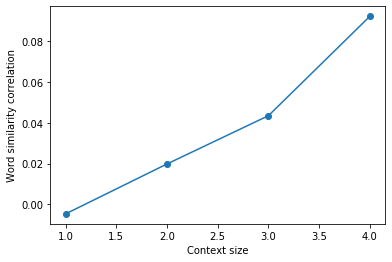

In [0]:
plt.plot(context_sizes, scores, marker='o')
plt.xlabel("Context size")
plt.ylabel("Word similarity correlation")